In [115]:
import datetime
import pickle
from os import getcwd
from os.path import join
import warnings

from hmmlearn.hmm import GaussianHMM
from matplotlib import cm, pyplot as plt
from matplotlib.dates import YearLocator, MonthLocator
from matplotlib.finance import quotes_historical_yahoo_ochl
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Hides deprecation warnings for sklearn
warnings.filterwarnings("ignore")

In [151]:
def obtain_prices_df(csv_filepath, start_date, end_date):    
    df = pd.read_csv(
        csv_filepath, header=0,
        names=[
            "Date", "Open", "High", "Low", 
            "Close", "Adj Close", "Volume"
        ],
        index_col="Date", parse_dates=True
    )
    df["Returns"] = df["Adj Close"].pct_change()
    df["Intraday Volatility"] = df["High"] - df["Low"]
    df["Fractional Change"] = (df["Close"] - df["Open"]) / df["Open"]
    df["Fractional High"] = (df["High"] - df["Open"]) / df["Open"]
    df["Fractional Low"] = (df["Open"] - df["Low"]) / df["Open"]
    df = df[start_date.strftime("%Y-%m-%d"):end_date.strftime("%Y-%m-%d")]
    df.dropna(inplace=True)
    return df

In [133]:
def plot_in_sample_hidden_states(hmm_model, df):
    # Predict the hidden states array
    hidden_states = hmm_model.predict(rets)
    # Create the correctly formatted plot
    fig, axs = plt.subplots(
        hmm_model.n_components, 
        sharex=True, sharey=True,
        figsize=(16, 14), dpi= 80, facecolor='w', edgecolor='k'
    )
    colors = cm.rainbow(
        np.linspace(0, 1, hmm_model.n_components)
    )
    for i, (ax, colour) in enumerate(zip(axs, colors)):
        mask = hidden_states == i
        ax.plot_date(
            df.index[mask], 
            df["Adj Close"][mask], 
            ".", linestyle='none', 
            c=colour
        )
        ax.set_title("Hidden State #%s" % i)
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_minor_locator(MonthLocator())
        ax.grid(True)
        
    plt.show()

In [153]:

# Create the SPY dataframe from the Yahoo Finance CSV
# and correctly format the returns for use in the HMM
csv_filepath = join(getcwd(), "../data/SPY.csv")
pickle_path = join(getcwd(), "../model/hmm_model_spy.pkl")
start_date = datetime.datetime(1994, 1, 1)
end_date = datetime.datetime(2017, 7, 1)
spy = obtain_prices_df(csv_filepath, start_date, end_date)

print(spy[:5])


               Open     High      Low    Close  Adj Close  Volume   Returns  \
Date                                                                          
1994-01-03  46.5937  46.6562  46.4062  46.4687  30.079590  960900 -0.002683   
1994-01-04  46.5312  46.6562  46.4687  46.6562  30.200966  164300  0.004035   
1994-01-05  46.7187  46.7812  46.5312  46.7500  30.261683  710900  0.002010   
1994-01-06  46.8125  46.8437  46.6875  46.7500  30.261683  201000  0.000000   
1994-01-07  46.8437  47.0625  46.7187  47.0312  30.443693  775500  0.006015   

            Intraday Volatility  Fractional Change  Fractional High  \
Date                                                                  
1994-01-03               0.2500          -0.002683         0.001341   
1994-01-04               0.1875           0.002686         0.002686   
1994-01-05               0.2500           0.000670         0.001338   
1994-01-06               0.1562          -0.001335         0.000666   
1994-01-07          

### HMM using SPY returns alone

Model Score: 18905.9870047


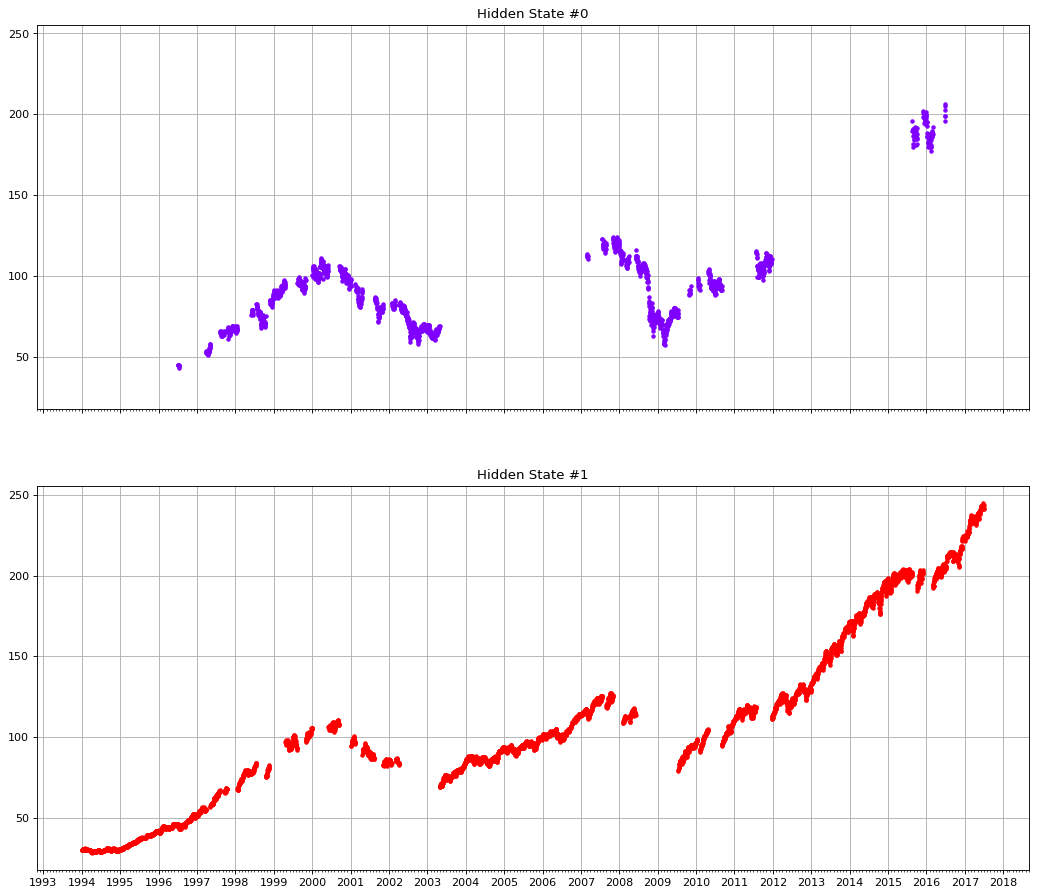

[[ 97.38948307   2.61051693]
 [  1.05412867  98.94587133]]


In [165]:
# Create the Gaussian Hidden markov Model and fit it
# to the SPY returns data using the Returns metric alone

rets = np.column_stack([spy["Returns"]])
hmm_model = GaussianHMM(
    n_components=2, covariance_type="diag", n_iter=1000
).fit(rets)
print("Model Score:", hmm_model.score(rets))

# Plot the in sample hidden states closing values
plot_in_sample_hidden_states(hmm_model, spy)

print(hmm_model.transmat_ * 100)

## HMM using SPY returns and trading volume

Model Score: -13517.3911754


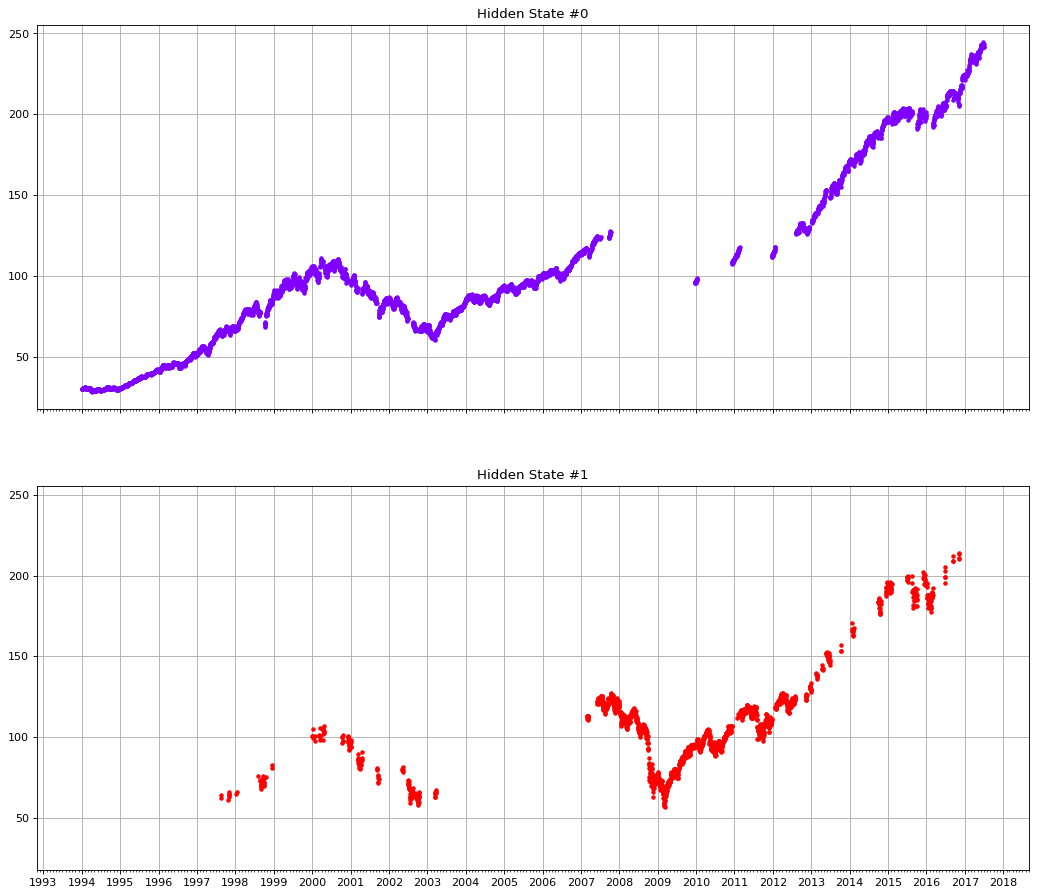

In [147]:
scaler = StandardScaler()
rets = scaler.fit_transform(spy[['Returns', 'Volume']])
hmm_model = GaussianHMM(
    n_components=2, covariance_type="spherical", n_iter=1000
).fit(rets)
print("Model Score:", hmm_model.score(rets))

plot_in_sample_hidden_states(hmm_model, spy)

## HMM using SPY returns, trading volume and intra-day volatility

Model Score: -19689.7238846


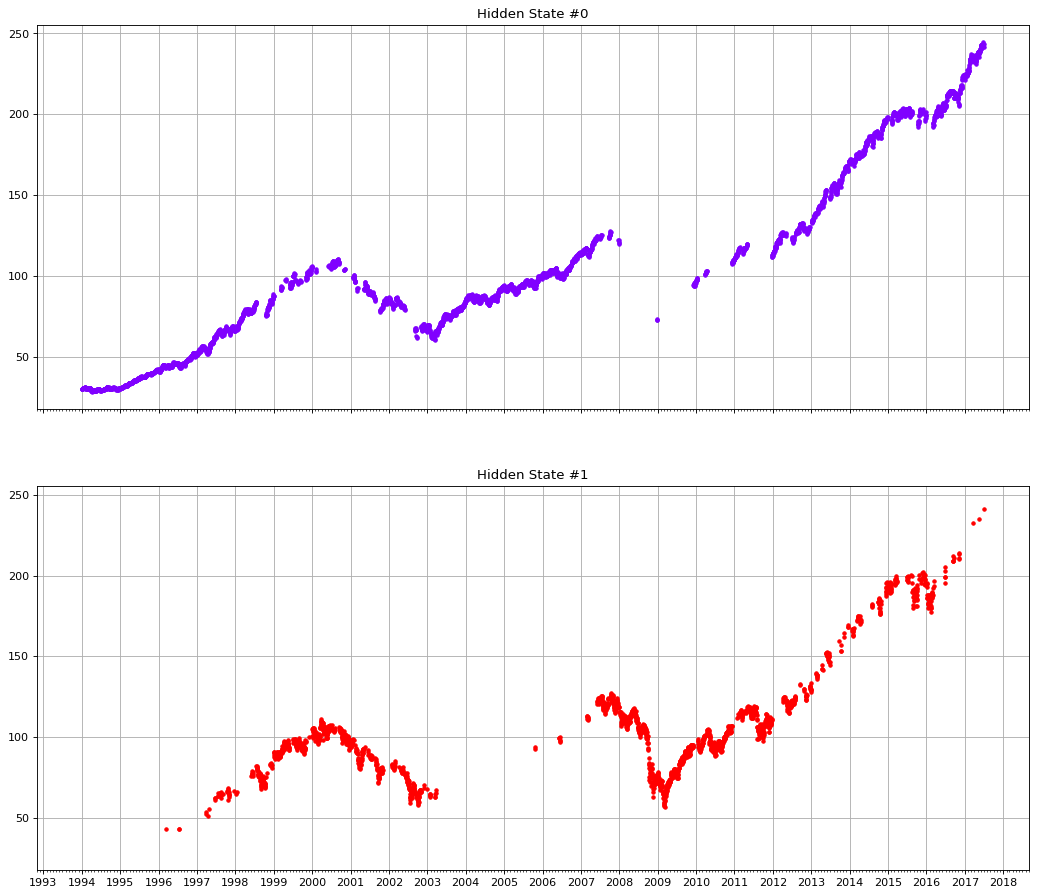

In [150]:
scaler = StandardScaler()
rets = scaler.fit_transform(spy[['Returns', 'Volume', 'Intraday Volatility']])
hmm_model = GaussianHMM(
    n_components=2, covariance_type="full", n_iter=1000
).fit(rets)
print("Model Score:", hmm_model.score(rets))

plot_in_sample_hidden_states(hmm_model, spy)

## HMM using SPY fractional change, high and low

Model Score: 69966.1551375


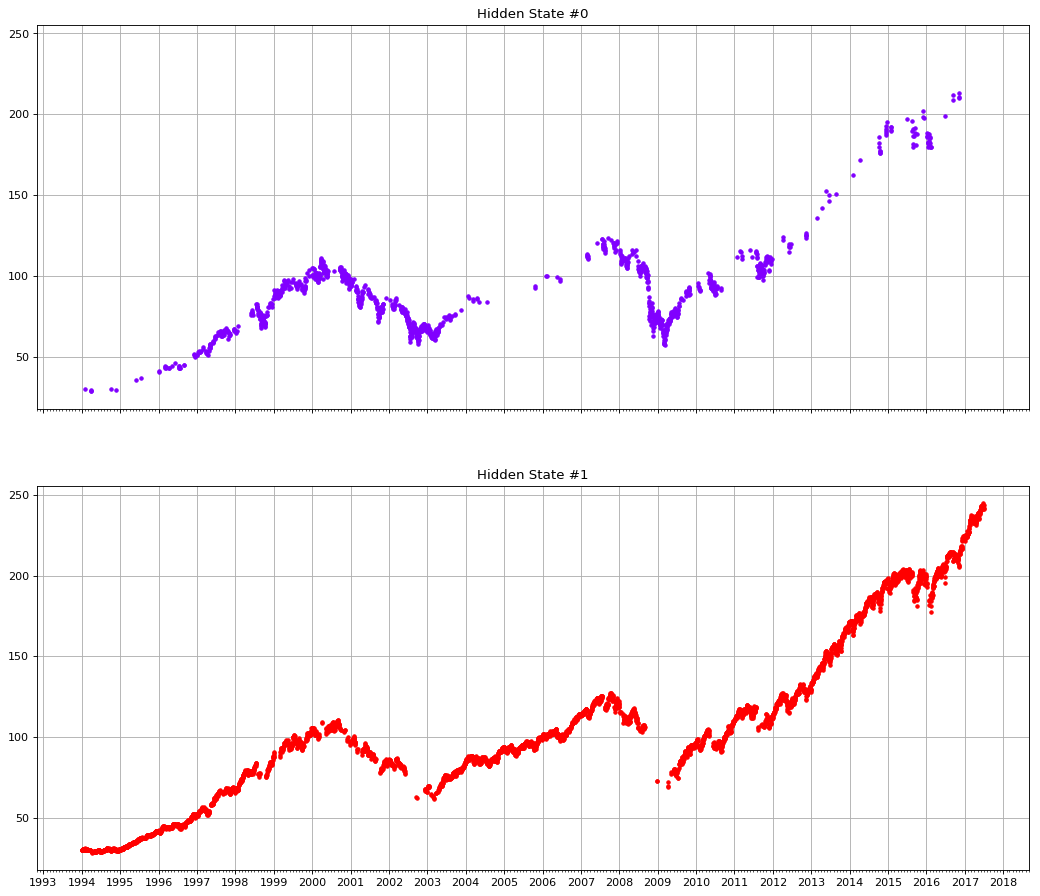

In [160]:
rets = spy[['Fractional Change', 'Fractional High', 'Fractional Low']]
hmm_model = GaussianHMM(
    n_components=2, covariance_type="full", n_iter=1000
).fit(rets)
print("Model Score:", hmm_model.score(rets))

plot_in_sample_hidden_states(hmm_model, spy)

[1] Hmmlearn tutorial; http://hmmlearn.readthedocs.io/en/latest/auto_examples/plot_hmm_stock_analysis.htmlu
[2] Stock Market Prediction Using Hidden Markov Models; http://www.cs.cmu.edu/~bdhingra/papers/stock_hmm.pdf